# CA4 - Data Science: World Cup Prediction (MLP) 

**Course:** Data Science  
**Assignment:** CA4 (Computer Assignment 4)  
**University:** University of Tehran  
**Instructors:** Dr. Bahrak, Dr. Yaghoobzadeh  

**Authors:** 

- Mahdy Mokhtari

- Alborz Mahmoudian

- Niloufar Mortazavi

---

#### Introduction

The assignment focuses on applying deep learning techniques across three domains: MLP (football match outcome prediction), CNN (image classification), and RNN (time series forecasting).  
This notebook specifically implements the **first task**: building and evaluating a **Multi-Layer Perceptron (MLP)** to predict the outcomes of FIFA World Cup 2022 matches using historical match data.

The goal is to:
- Load and prepare football match data.
- Design and train an MLP using PyTorch.
- Evaluate the model performance.
- Use the trained model to simulate the 2022 FIFA World Cup tournament outcomes.



In [272]:
import numpy as np
import torch.nn as nn
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

## 0. Dataset Loading

In this task, we work with a football dataset that includes match results from the qualifiers and the main tournament of the Qatar 2022 FIFA World Cup. The dataset contains 18 features that describe team names, goal statistics, historical match differences, and match outcomes.

Key features include:
- `home_team`, `away_team`: Teams participating in each match.
- `home_goals`, `away_goals`: Number of goals scored by each side.
- `wcm`: Indicates whether the match was part of the World Cup tournament (1) or a qualifier (0).
- `dif_*`: Statistical differences (e.g., matches played, won, goals scored/conceded) between home and away teams.
- `status`: The target label, representing the match outcome:
  - 1 = Home Win  
  - 2 = Draw  
  - 3 = Home Loss

Now we will load the dataset.


In [273]:
csv_file_path = 'matches.csv'
df = pd.read_csv(csv_file_path)

## 1. Exploratory Data Analysis (EDA)

In this section, we analyze the dataset to understand its structure and characteristics:

- Check data types, missing values, and dataset shape.
- Examine the distribution of the target variable (`status`) to assess class balance.
- Explore numerical features related to match history and performance differences.
- Use visual tools (histograms, box plots, correlation matrix) to uncover patterns and relationships.
- Identify potential data leakage (e.g., goals scored) and assess feature scaling needs.

This helps ensure the data is clean, meaningful, and ready for model training.


In [274]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812 entries, 0 to 17811
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            17812 non-null  int64  
 1   home_team             17812 non-null  object 
 2   home_goals            17812 non-null  int64  
 3   away_goals            17812 non-null  int64  
 4   away_team             17812 non-null  object 
 5   wcm                   17812 non-null  int64  
 6   dif_inter_match       17812 non-null  float64
 7   dif_inter_match_won   17812 non-null  float64
 8   dif_inter_match_lost  17812 non-null  float64
 9   dif_inter_match_tie   17812 non-null  float64
 10  dif_inter_goals_sco   17812 non-null  float64
 11  dif_inter_goals_con   17812 non-null  float64
 12  dif_wc_match          17812 non-null  float64
 13  dif_wc_match_won      17812 non-null  float64
 14  dif_wc_match_lost     17812 non-null  float64
 15  dif_wc_match_tied  

In [275]:
print(df.describe())

         Unnamed: 0    home_goals    away_goals           wcm  \
count  17812.000000  17812.000000  17812.000000  17812.000000   
mean    8905.500000      1.700539      1.137042      0.050528   
std     5142.025833      1.668345      1.293980      0.219037   
min        0.000000      0.000000      0.000000      0.000000   
25%     4452.750000      1.000000      0.000000      0.000000   
50%     8905.500000      1.000000      1.000000      0.000000   
75%    13358.250000      2.000000      2.000000      0.000000   
max    17811.000000     31.000000     17.000000      1.000000   

       dif_inter_match  dif_inter_match_won  dif_inter_match_lost  \
count     17812.000000         17812.000000          17812.000000   
mean         39.204188            24.746407              6.269313   
std         494.412966           285.691530            118.601085   
min        -966.000000          -578.000000           -331.000000   
25%        -458.000000          -242.000000            -95.000000   


In [276]:
print(f"The Shape of the matches dataframe is: {df.shape}")

print("\n-> Missing Values:")
print(df.isnull().sum())

The Shape of the matches dataframe is: (17812, 19)

-> Missing Values:
Unnamed: 0              0
home_team               0
home_goals              0
away_goals              0
away_team               0
wcm                     0
dif_inter_match         0
dif_inter_match_won     0
dif_inter_match_lost    0
dif_inter_match_tie     0
dif_inter_goals_sco     0
dif_inter_goals_con     0
dif_wc_match            0
dif_wc_match_won        0
dif_wc_match_lost       0
dif_wc_match_tied       0
dif_wc_goals_sco        0
dif_wc_goals_con        0
status                  0
dtype: int64


No missing values in any of the columns.

#### Distributions of Key Numerical Features

These features show the historical differences between the home and away teams:
- `dif_inter_match_won`: Past international wins
- `dif_inter_goals_sco`: Goals scored in international matches
- `dif_wc_match_won`: World Cup wins
- `dif_wc_goals_sco`: World Cup goals scored

These distributions provide insight into team strength. Features like these are expected to correlate with match outcomes and help the MLP model learn meaningful patterns.


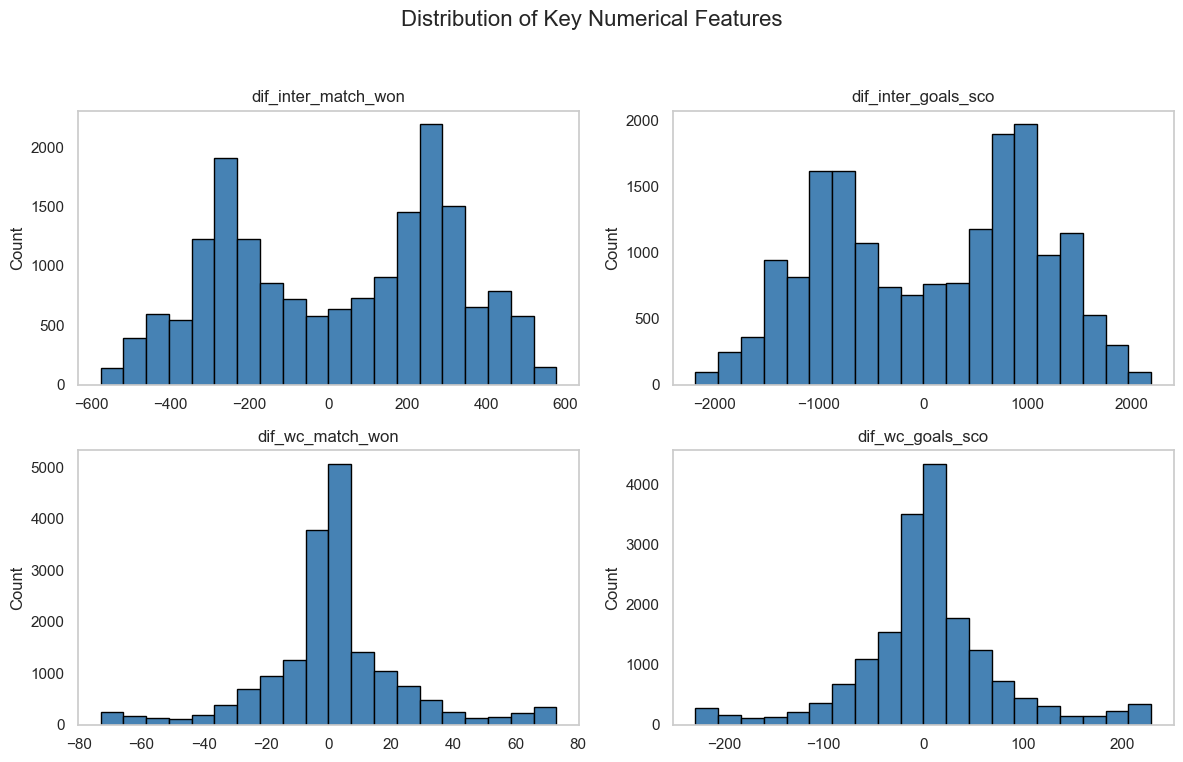

In [ ]:
# Selected interesting numerical features
interesting_features = [
    'dif_inter_match_won',
    'dif_inter_goals_sco',
    'dif_wc_match_won',
    'dif_wc_goals_sco'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(interesting_features):
    df[feature].plot.hist(bins=20, edgecolor='black', ax=axes[i], color='steelblue')
    axes[i].set_title(feature)
    axes[i].grid(False)  # Disable grid lines
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('')

plt.suptitle('Distribution of Key Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Some Insights from Feature Distributions I selected

From the histograms above, we dicsover two distinct types of distributions:

- `dif_wc_match_won` and `dif_wc_goals_sco` appear to follow <u>**normal (bell-shaped) distributions**</u>, centered around 0. This suggests that for many matches, the home and away teams had relatively similar World Cup performance histories.
  
- `dif_inter_match_won` and `dif_inter_goals_sco` show a <u>**bimodal distribution**</u>, where the data seems to form **two overlapping normal distributions**. This could indicate two dominant groups of teams — strong vs. weak — leading to large differences in past international wins or goals scored.

---

#### Target Field (label): Match Outcome (`status`)

The `status` column represents the result of each match:
- `1`: Home win  
- `2`: Tie  
- `3`: Home loss


C:\Users\NoteBook\AppData\Local\Temp\ipykernel_1676\2144892849.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_label', data=df, palette='Set2')


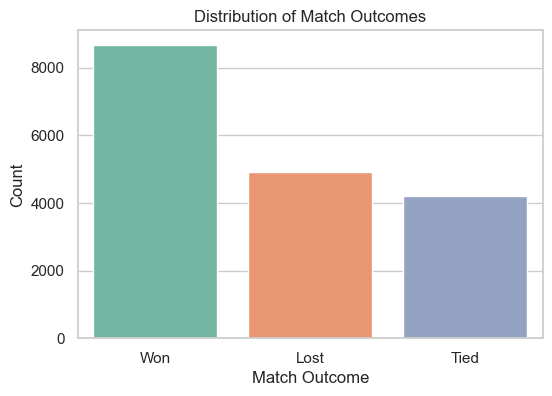

In [304]:
status_labels = {1: 'Won', 2: 'Tied', 3: 'Lost'}
df['status_label'] = df['status'].map(status_labels)

plt.figure(figsize=(6, 4))
sns.countplot(x='status_label', data=df, palette='Set2')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Match Outcome')
plt.ylabel('Count')
plt.show()


#### Insights from Label (Target output) distribution

The distribution is **not balanced** — most matches end in **home wins**, with fewer lhome losses and even fewer ties. This imbalance can affect model performance, especially if it learns to overpredict the majority class (home win) to maximize accuracy.

The dominance of home wins is expected due to the well-known **"home advantage"** in football, where teams perform better on their home

#### Correlation of Features with status

In [ ]:
import numpy as np

numeric_df = df.select_dtypes(include=np.number)

correlations_with_status = numeric_df.corr()['status'].drop('status').sort_values(ascending=False)

print("Correlation of Features with Target Variable (status):")
display(correlations_with_status)


Correlation of Features with Target Variable (status):


away_goals              0.619539
Unnamed: 0             -0.005759
wcm                    -0.034958
dif_inter_match_lost   -0.228574
dif_inter_goals_con    -0.293829
dif_wc_match_won       -0.336486
dif_wc_goals_sco       -0.346081
dif_inter_match        -0.364432
dif_inter_match_tie    -0.367851
dif_wc_match_lost      -0.378876
dif_wc_goals_con       -0.380643
dif_inter_goals_sco    -0.381168
dif_inter_match_won    -0.384216
dif_wc_match_tied      -0.389661
dif_wc_match           -0.390647
home_goals             -0.584736
Name: status, dtype: float64

The reason that the away goals is positive ocrrelation and the rest are negative becuase the winning of the away team is encoded as 3 and the win of the home team is encoded at 1 so how much the away team scores more goals then the correlation is postive meaning the status is higher being more near to 3 than 1.

But the rest of the features are (home - away) so its natural that the they have a negetive correlation becuas they support home wins which is less in number encoded(1).

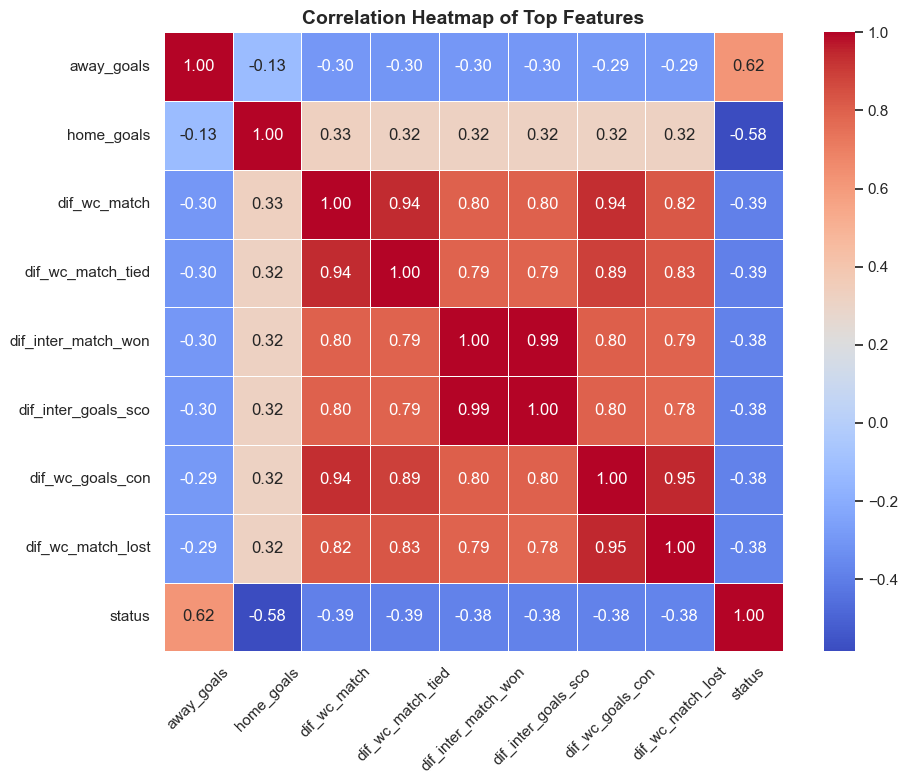

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = correlations_with_status.abs().sort_values(ascending=False).head(8).index.tolist()
top_features.append('status')

corr_matrix = df[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Top Features', fontsize=14, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


###################################### make the plot better in Professor ##############################333


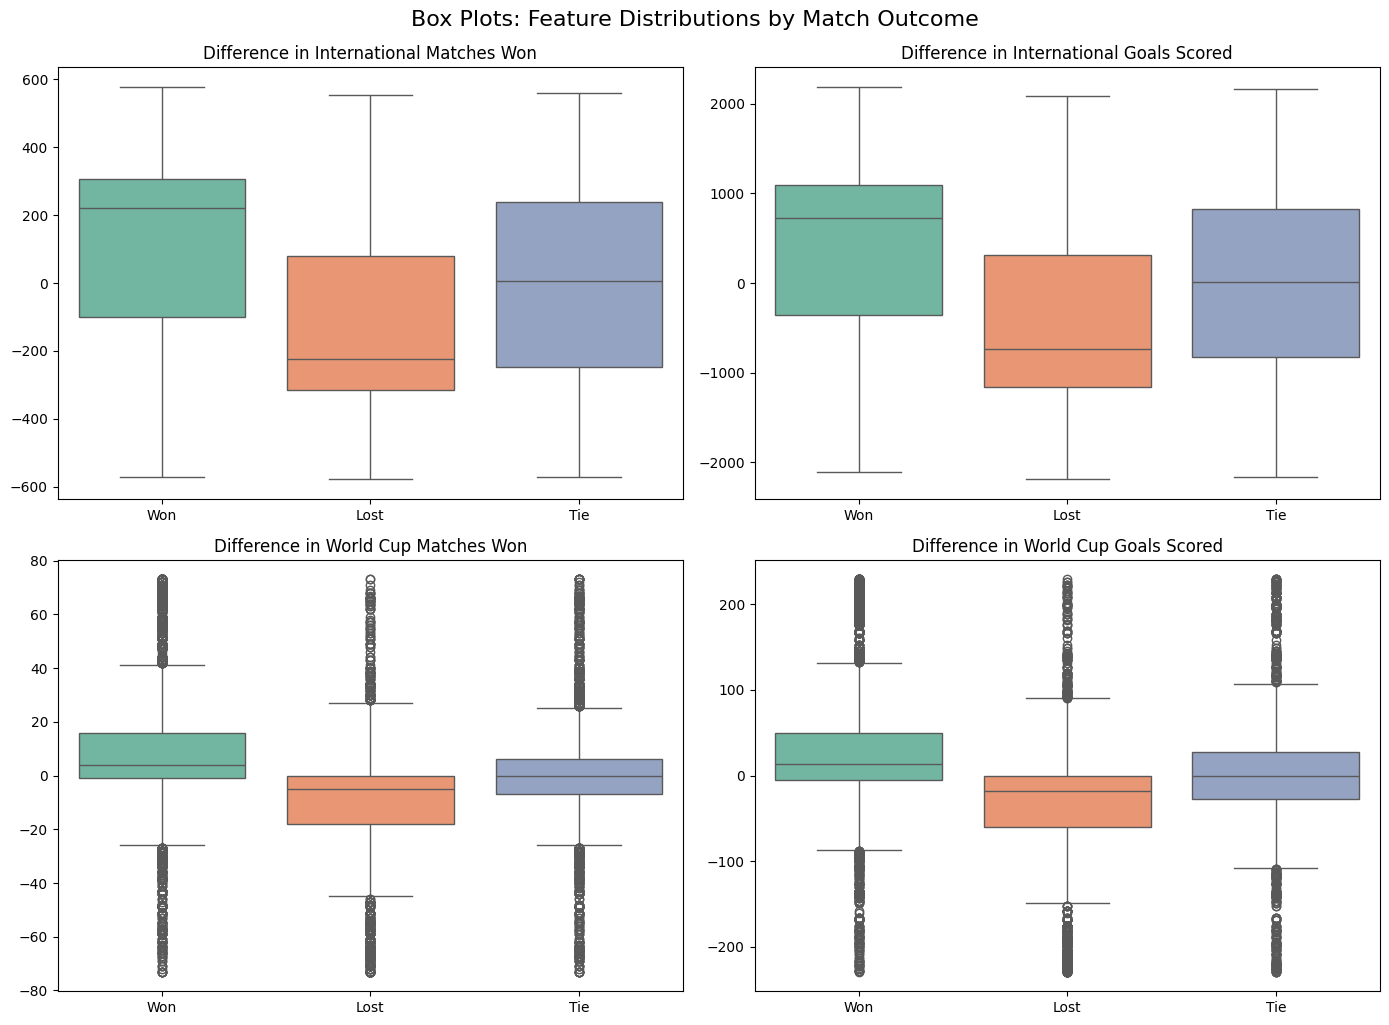

In [ ]:
sns.set(style="whitegrid")
plt.style.use('default')

df['Outcome_Label'] = df['status'].replace({1: 'Won', 2: 'Tie', 3: 'Lost'})

titles = {
    'dif_inter_match_won': 'Difference in International Matches Won',
    'dif_inter_goals_sco': 'Difference in International Goals Scored',
    'dif_wc_match_won': 'Difference in World Cup Matches Won',
    'dif_wc_goals_sco': 'Difference in World Cup Goals Scored'
}

features = list(titles.keys())

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x='Outcome_Label', y=feature, hue='Outcome_Label',
                palette='Set2', legend=False)
    plt.title(titles[feature])
    plt.xlabel('')
    plt.ylabel('')
    plt.grid(False)

plt.tight_layout()
plt.suptitle('Box Plots: Feature Distributions by Match Outcome', fontsize=16, y=1.02)
plt.show()


In [282]:
# Average goals scored by home and away teams
avg_home_goals = df['home_goals'].mean()
avg_away_goals = df['away_goals'].mean()

print(f"Average Home Goals: {avg_home_goals:.2f}")
print(f"Average Away Goals: {avg_away_goals:.2f}")


Average Home Goals: 1.70
Average Away Goals: 1.14


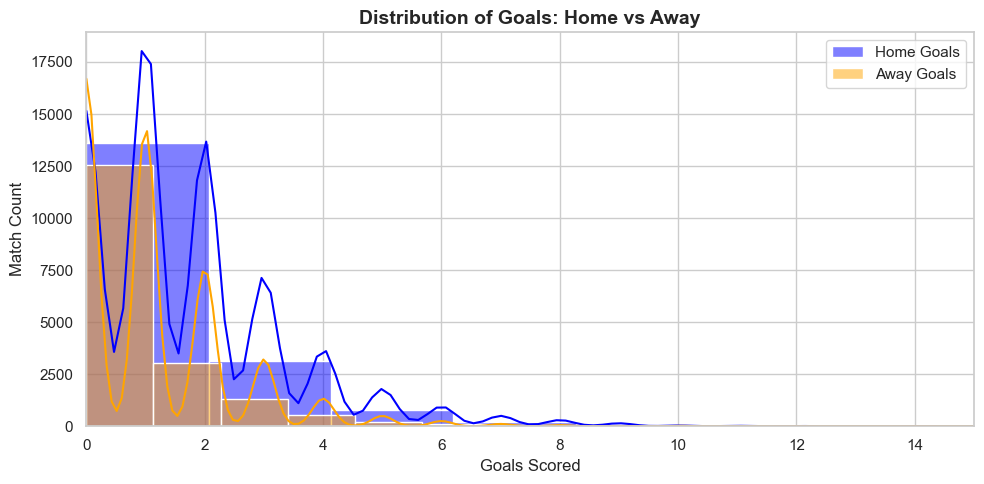

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
sns.set(style="whitegrid")  # You can also change this to "white" if you prefer cleaner background

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(df['home_goals'], color='blue', label='Home Goals', kde=True, bins=15, stat="count")
sns.histplot(df['away_goals'], color='orange', label='Away Goals', kde=True, bins=15, stat="count")

# Customization
plt.title('Distribution of Goals: Home vs Away', fontsize=14, weight='bold')
plt.xlabel('Goals Scored', fontsize=12)
plt.ylabel('Match Count', fontsize=12)
plt.xlim(0, 15)
plt.legend()
plt.tight_layout()
plt.show()


#### Why does the KDE line look wavy? Insight from Prevoius Plot.
The KDE curve is a smoothed estimate of the data distribution. Instead of counting exact bins like a histogram, KDE:

Places a smooth "bump" (kernel) over each data point

Adds up all these bumps to get a smooth curve that approximates the distribution

So why is it wavy?
That "wavy" behavior happens due to:

Discrete values: Goals are whole numbers (0, 1, 2...), so there are peaks at exact integers and nothing in between.

Sharp changes in frequency: If many matches had exactly 1 or 2 goals, and fewer had 3 or 4, the KDE tries to smooth this — but it still reflects those rapid frequency changes as wiggles.

In [284]:
# Count of match outcomes
status_counts = df['status'].value_counts().sort_index()

home_win_rate = status_counts.get(1, 0) / len(df)
tie_rate = status_counts.get(2, 0) / len(df)
away_win_rate = status_counts.get(3, 0) / len(df)

print(f"Home Win Rate: {home_win_rate:.2%}")
print(f"Tie Rate: {tie_rate:.2%}")
print(f"Away Win Rate: {away_win_rate:.2%}")


Home Win Rate: 48.70%
Tie Rate: 23.64%
Away Win Rate: 27.66%


In [285]:
# Features that cause data leakage and must be removed
leakage_features = ['home_goals', 'away_goals', 'home_team', 'away_team', 'status']

X = df.drop(columns=leakage_features)

y = df['status']

print("Features ready for model training:")
print(X.columns.to_list())


Features ready for model training:
['Unnamed: 0', 'wcm', 'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost', 'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con', 'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost', 'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con']


## 2. Data Preparation

- **Training Data**: Use only matches with `wcm = 0` (qualifiers).
- **Prediction Data**: Reserve `wcm = 1` (World Cup matches) for final evaluation.
- **Feature Selection**: Drop `home_team`, `away_team`, `home_goals`, `away_goals`, and `status` from inputs.
- **Target**: Use the `status` column (1 = home win, 2 = tie, 3 = home loss).
- **Reason for Exclusion**: Team names and goal counts cause data leakage or model bias.
- **Label Encoding**: Convert `status` to numeric labels using `LabelEncoder`.
- **Standardization**: Fit `StandardScaler` on training data and transform both sets.
- **Tensor Conversion**: Convert scaled data to PyTorch tensors for model input.

These steps ensure the model is trained fairly and generalizes well.


In [286]:
# Count and percentage of wcm values
wcm_counts = df['wcm'].value_counts().sort_index()
total = len(df)

for val in wcm_counts.index:
    percent = (wcm_counts[val] / total) * 100
    print(f"wcm = {val}: {wcm_counts[val]} matches ({percent:.2f}%)")


wcm = 0: 16912 matches (94.95%)
wcm = 1: 900 matches (5.05%)


#### Excluding columns with Data Leakage

Data leakage refers to the unintended use of information in the training data that would not be available at prediction time, and which gives the model unfair insight into the target variable. This often leads to overfitting and overly optimistic performance during training, but poor generalization on real-world data.

In the football match prediction task, the label (`status`) indicates whether the home team won, tied, or lost.  
If we include features like:

- `home_goals`
- `away_goals`

These literally determine the result:

- If `home_goals > away_goals` → it's a home win (`status = 1`)
- If equal → tie
- If `away_goals > home_goals` → it's a home loss


We exclude `home_team` and `away_team` because they are just team identifiers, not performance features.  
Including them would cause the model to memorize specific team names (e.g., "Germany always wins") rather than learning from meaningful patterns like goal differences or match history.  
This leads to overfitting and poor generalization, especially on unseen teams.


In [287]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Filter datasets
df_non_worldcup = df[df['wcm'] == 0].copy()
df_worldcup = df[df['wcm'] == 1].copy()

# Leakage features
leakage_features = ['home_team', 'away_team', 'home_goals', 'away_goals', 'status']
feature_columns = [col for col in df.columns if col not in leakage_features]

# Split non-World Cup data into train/test (80/20)
X = df_non_worldcup.drop(columns=leakage_features)
y = df_non_worldcup['status'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test_worldcup = df_worldcup.drop(columns=leakage_features)
y_test_worldcup = df_worldcup['status'].copy()


##### **Standardization vs. Normalization**

| Method              | Description                                                           | Output Range                         | When to Use                                                                                                 |
| ------------------- | --------------------------------------------------------------------- | ------------------------------------ | ----------------------------------------------------------------------------------------------------------- |
| **Standardization** | Rescales features to have **mean = 0** and **standard deviation = 1** | Not bounded (can be any real number) | When features are normally distributed or when using models like **MLPs**, SVMs, etc.                       |
| **Normalization**   | Rescales features to **\[0, 1]** or **\[-1, 1]** (min-max scaling)    | Fixed range (e.g., \[0, 1])          | When features don’t follow a Gaussian distribution or when you need bounded input (e.g., images, distances) |


#### Why we prefer **Standardization** for MLP here:

* MLPs use **gradient-based optimization**, which is sensitive to input scales.
* Standardization centers data at 0 and normalizes variance, helping the MLP **converge faster and more stably**.
* It performs better when **features are approximately Gaussian**, which is common for statistical differences like `dif_wc_goals_sco`, etc.


Since we're working with numerical features in a neural network, standardization is the most appropriate choice.



In [288]:
# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_worldcup = scaler.transform(X_test_worldcup)

# Check shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_test_worldcup: {X_test_worldcup.shape}, y_test_worldcup: {y_test_worldcup.shape}")

X_train: (13529, 14), y_train: (13529,)
X_test: (3383, 14), y_test: (3383,)
X_test_worldcup: (900, 14), y_test_worldcup: (900,)


> Warning! One important thing to note here is to avoid data leakage from test set to 
train set. The StandardScalar should be fit only to train data and fitting the scalar to 
train and test set jointly will cause leakage.

>  Note: Although the instructions mention a 70/30 train-test split, we follow the higher-level guidance and train only on `wcm = 0` to simulate real-world prediction on World Cup (`wcm = 1`) matches.


In [289]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

x_test_worldcup_tensor = torch.tensor(X_test_worldcup, dtype=torch.float32)
y_test_worldcup_tensor = torch.tensor(y_test_worldcup.values - 1, dtype=torch.long)

print(f"X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}")
print(f"X_test_tensor: {X_test_tensor.shape}, y_test_tensor: {y_test_tensor.shape}")
print(f"x_test_worldcup_tensor: {x_test_worldcup_tensor.shape}, y_test_worldcup_tensor: {y_test_worldcup_tensor.shape}")


X_train_tensor: torch.Size([13529, 14]), y_train_tensor: torch.Size([13529])
X_test_tensor: torch.Size([3383, 14]), y_test_tensor: torch.Size([3383])
x_test_worldcup_tensor: torch.Size([900, 14]), y_test_worldcup_tensor: torch.Size([900])


**Note on Label Adjustment for CrossEntropyLoss**  
PyTorch’s `CrossEntropyLoss` expects class labels to be zero-based (starting from 0).  
Since our `status` labels are originally 1 (Home Win), 2 (Tie), and 3 (Home Loss), we subtract 1 to shift them to 0, 1, and 2 respectively.  
This avoids `IndexError` and ensures compatibility with the model's output layer.


## 3. Model Definition

We define a simple neural network (MLP) using PyTorch to predict match results.  
It takes the match data as input, processes it through a few layers, and outputs one of the three possible outcomes: home win, tie, or home loss.


In [290]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, input_size=14, hidden1=8, hidden2=32, output_size=3):
        super(MLPClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden1)   # Input → Hidden Layer 1
        self.fc2 = nn.Linear(hidden1, hidden2)       # Hidden Layer 1 → Hidden Layer 2
        self.fc3 = nn.Linear(hidden2, output_size)   # Hidden Layer 2 → Output Layer

    def forward(self, x):
        x = F.relu(self.fc1(x))   # Activation 
        x = F.relu(self.fc2(x))   # Activation 
        x = self.fc3(x)           # Output logits (no softmax, handled by loss)
        return x


**NOTE**: We do not apply `softmax` in the model’s output layer because `nn.CrossEntropyLoss()` in PyTorch already includes `LogSoftmax` internally.  
Applying it manually would lead to incorrect loss calculations.


## 4. Model Training

To train our MLP model, we:

- Use `CrossEntropyLoss` as the loss function for multi-class classification.
- Choose an optimizer (e.g., Adam) to update model weights.
- Run the training loop for several epochs:
  - Clear previous gradients with `optimizer.zero_grad()`
  - Pass input through the model to get predictions
  - Compute the loss using actual labels
  - Call `loss.backward()` to compute gradients
  - Use `optimizer.step()` to update the model

Repeating this process allows the model to learn patterns from the training data.


In [291]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
num_epochs = 35
learning_rate = 0.003
# batch_size = 64  

In [293]:
model = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
print(device)

cpu


In [294]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    optimizer.zero_grad()      # Clear gradients
    loss.backward()            # Compute gradients
    optimizer.step()           # Update weights

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/35], Loss: 1.1529
Epoch [2/35], Loss: 1.1403
Epoch [3/35], Loss: 1.1283
Epoch [4/35], Loss: 1.1168
Epoch [5/35], Loss: 1.1057
Epoch [6/35], Loss: 1.0948
Epoch [7/35], Loss: 1.0841
Epoch [8/35], Loss: 1.0735
Epoch [9/35], Loss: 1.0631
Epoch [10/35], Loss: 1.0529
Epoch [11/35], Loss: 1.0430
Epoch [12/35], Loss: 1.0335
Epoch [13/35], Loss: 1.0246
Epoch [14/35], Loss: 1.0165
Epoch [15/35], Loss: 1.0094
Epoch [16/35], Loss: 1.0034
Epoch [17/35], Loss: 0.9987
Epoch [18/35], Loss: 0.9953
Epoch [19/35], Loss: 0.9931
Epoch [20/35], Loss: 0.9920
Epoch [21/35], Loss: 0.9916
Epoch [22/35], Loss: 0.9917
Epoch [23/35], Loss: 0.9919
Epoch [24/35], Loss: 0.9919
Epoch [25/35], Loss: 0.9915
Epoch [26/35], Loss: 0.9906
Epoch [27/35], Loss: 0.9891
Epoch [28/35], Loss: 0.9871
Epoch [29/35], Loss: 0.9848
Epoch [30/35], Loss: 0.9824
Epoch [31/35], Loss: 0.9799
Epoch [32/35], Loss: 0.9775
Epoch [33/35], Loss: 0.9753
Epoch [34/35], Loss: 0.9735
Epoch [35/35], Loss: 0.9719


## 5. Model Evaluation

After training, we assess the model's performance using the test set. Accuracy above 50% is considered successful due to the unpredictable nature of football outcomes. High accuracy (e.g., over 90%) is not expected in this context.


In [295]:
import torch
from sklearn.metrics import accuracy_score

model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predictions = torch.max(outputs, 1)

accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 54.80%


## 6. Run FIFA World Cup!

In this final part im going to do two things:

1. see how does the test data that was `wcm=1` will be and how much accurate we will predict .

2. Secondly I will simulate and put the group stage and everything together and predict the outcome of each match until we see who becomes the champion. 


In [296]:
model.eval()

with torch.no_grad():
    outputs = model(x_test_worldcup_tensor)
    predicted_classes = torch.argmax(outputs, dim=1)

accuracy = accuracy_score(
    y_test_worldcup_tensor.cpu().numpy(),
    predicted_classes.cpu().numpy()
)

print(f"World Cup Test Accuracy: {accuracy * 100:.2f}%")

World Cup Test Accuracy: 55.56%


In [ ]:
import random
import torch
import numpy as np

def predict_match_result(model, team1, team2, matches_df, feature_columns, device, scaler=None):
    """
    Predict the result of team1 vs team2 using the trained model and matches dataframe.
    
    Returns one of:
    - "Won"  → team1 wins
    - "Tied" → tie
    - "Lost" → team1 loses
    """
    match = matches_df[
        (((matches_df['home_team'] == team1) & (matches_df['away_team'] == team2)) |
         ((matches_df['home_team'] == team2) & (matches_df['away_team'] == team1))) &
        (matches_df['wcm'] == 1)
    ]

    if match.empty:
        match = matches_df[
            ((matches_df['home_team'] == team1) & (matches_df['away_team'] == team2)) |
            ((matches_df['home_team'] == team2) & (matches_df['away_team'] == team1))
        ]

    if match.empty:
        result = random.choice(["Won", "Tied", "Lost"])
        print(f"No match found between {team1} and {team2} in dataset. Randomly predicted result: {result}")
        return result

    row = match.iloc[[0]]  

    if scaler:
        features = scaler.transform(row[feature_columns])
    else:
        features = row[feature_columns].values.astype(np.float32)

    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        output = model(features_tensor)
        prediction = torch.argmax(output, dim=1).item()

    if row['home_team'].iloc[0] == team1:
        result_map = {0: "Won", 1: "Tied", 2: "Lost"}
    else:
        result_map = {0: "Lost", 1: "Tied", 2: "Won"}

    return result_map[prediction]


In [ ]:
import pandas as pd
import random

def simulate_group_stage(model, matches_df, feature_columns, device, scaler):
    groups = {
        'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
        'B': ['England', 'Iran', 'USA', 'Wales'],
        'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
        'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
        'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
        'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
        'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
        'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
    }

    group_results = {}

    for group_name, teams in groups.items():
        print(f"\n🔸 Simulating Group {group_name}...")
        points = {team: 0 for team in teams}
        matches = []

        # Simulate all unique match pairs (6 matches per group)
        for i in range(len(teams)):
            for j in range(i+1, len(teams)):
                team1, team2 = teams[i], teams[j]
                result = predict_match_result(model, team1, team2, matches_df, feature_columns, device, scaler)
                matches.append((team1, team2, result))

                if result == "Won":
                    points[team1] += 3
                elif result == "Tied":
                    points[team1] += 1
                    points[team2] += 1
                else:
                    points[team2] += 3

        df = pd.DataFrame(list(points.items()), columns=["Team", "Points"])
        df["Random"] = [random.random() for _ in range(len(df))]
        df = df.sort_values(by=["Points", "Random"], ascending=[False, False]).reset_index(drop=True)

        df["Standing"] = df.index + 1

        print(f"\nStandings for Group {group_name}:")
        print(df[["Standing", "Team", "Points"]].to_string(index=False))

        group_results[group_name] = {
            "standings": df.drop(columns=["Random"]),
            "matches": matches
        }

    return group_results


In [ ]:
import random

def simulate_knockout_stage(group_results, model, matches_df, feature_columns, device, scaler):
    """
    Simulate the knockout stage based on group results and return 1st, 2nd, and 3rd place.
    """
    round_of_16 = [
        (group_results['A']['standings'].iloc[0]['Team'], group_results['B']['standings'].iloc[1]['Team']),
        (group_results['C']['standings'].iloc[0]['Team'], group_results['D']['standings'].iloc[1]['Team']),
        (group_results['E']['standings'].iloc[0]['Team'], group_results['F']['standings'].iloc[1]['Team']),
        (group_results['G']['standings'].iloc[0]['Team'], group_results['H']['standings'].iloc[1]['Team']),
        (group_results['B']['standings'].iloc[0]['Team'], group_results['A']['standings'].iloc[1]['Team']),
        (group_results['D']['standings'].iloc[0]['Team'], group_results['C']['standings'].iloc[1]['Team']),
        (group_results['F']['standings'].iloc[0]['Team'], group_results['E']['standings'].iloc[1]['Team']),
        (group_results['H']['standings'].iloc[0]['Team'], group_results['G']['standings'].iloc[1]['Team']),
    ]

    def simulate_round(matches):
        winners = []
        for team1, team2 in matches:
            result = predict_match_result(model, team1, team2, matches_df, feature_columns, device, scaler)
            if result == "Won":
                winners.append(team1)
            elif result == "Lost":
                winners.append(team2)
            else:
                winner = random.choice([team1, team2])
                print(f"Knockout Stage Tiebreaker between {team1} and {team2} → Randomly selected: {winner}")
                winners.append(winner)

        return winners

    # Round of 16 → Quarter-finals
    qf_teams = simulate_round(round_of_16)

    # Quarter-finals
    quarter_finals = [(qf_teams[i], qf_teams[i+1]) for i in range(0, 8, 2)]
    sf_teams = simulate_round(quarter_finals)

    # Semi-finals
    semi_finals = [(sf_teams[0], sf_teams[1]), (sf_teams[2], sf_teams[3])]
    finalists = simulate_round(semi_finals)

    # Final match
    final_result = predict_match_result(model, finalists[0], finalists[1], matches_df, feature_columns, device, scaler)
    if final_result == "Won":
        first = finalists[0]
        second = finalists[1]
    elif final_result == "Lost":
        first = finalists[1]
        second = finalists[0]
    else:
        first, second = random.sample(finalists, 2)

    # 3rd place match between semi-final losers
    third_place_match = [team for team in sf_teams if team not in finalists]
    third_result = predict_match_result(model, third_place_match[0], third_place_match[1], matches_df, feature_columns, device, scaler)
    if third_result == "Won":
        third = third_place_match[0]
    elif third_result == "Lost":
        third = third_place_match[1]
    else:
        third = random.choice(third_place_match)

    return first, second, third


In [300]:
group_results = simulate_group_stage(model, df, feature_columns, device, scaler)


🔸 Simulating Group A...
No match found between Qatar and Senegal in dataset. Randomly predicted result: Lost
No match found between Qatar and Netherlands in dataset. Randomly predicted result: Tied
No match found between Senegal and Netherlands in dataset. Randomly predicted result: Won

Standings for Group A:
 Standing        Team  Points
        1     Senegal       6
        2     Ecuador       6
        3 Netherlands       4
        4       Qatar       1

🔸 Simulating Group B...
No match found between England and Iran in dataset. Randomly predicted result: Tied
No match found between England and USA in dataset. Randomly predicted result: Tied
No match found between Iran and USA in dataset. Randomly predicted result: Tied
No match found between USA and Wales in dataset. Randomly predicted result: Won

Standings for Group B:
 Standing    Team  Points
        1     USA       5
        2 England       5
        3    Iran       5
        4   Wales       0

🔸 Simulating Group C...

Stand

In [301]:
first, second, third = simulate_knockout_stage(group_results, model, df, feature_columns, device, scaler)

print("\n🏆 Final Results:")
print("1st Place:", first)
print("2nd Place:", second)
print("3rd Place:", third)


No match found between Senegal and England in dataset. Randomly predicted result: Won
No match found between USA and Ecuador in dataset. Randomly predicted result: Won
No match found between Senegal and Argentina in dataset. Randomly predicted result: Lost
No match found between USA and France in dataset. Randomly predicted result: Won
No match found between USA and Spain in dataset. Randomly predicted result: Won
No match found between Argentina and USA in dataset. Randomly predicted result: Won

🏆 Final Results:
1st Place: Argentina
2nd Place: USA
3rd Place: Germany
